In [1]:
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ConstantVectorSource,
    DiagramBuilder,
    LeafSystem,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
)
from helper import (
    CartTriplePendulumPlant
)

In [2]:
meshcat = StartMeshcat()
meshcat.Set2dRenderMode(xmin=-5, xmax=5, ymin=-3.1, ymax=3.1)

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
class AccelerationController(LeafSystem):
    def __init__(self, cart_triple_pendulum):
        LeafSystem.__init__(self)
        self.DeclareVectorInputPort("a_cart", 1)
        self.DeclareVectorInputPort("x", 8)
        self.DeclareVectorOutputPort("u", 1, self.DoCalcVectorOutput)
        self.cart_triple_pendulum = cart_triple_pendulum

    def DoCalcVectorOutput(
        self,
        context,
        output,  # force on cart
    ):
        # unpack plant state from input port
        a_ref = self.get_input_port(0).Eval(context)[0]
        x = self.get_input_port(1).Eval(context)
        q = x[0:4]
        q_dot = x[4:8]

        # extract manipulator equations: M*a + Cv = B*u + tauG
        plant = self.cart_triple_pendulum
        M = plant.CalcMassMatrixViaInverseDynamics(context)
        Cv = plant.CalcBiasTerm(context)
        B = plant.MakeActuationMatrix()
        tauG = plant.CalcGravityGeneralizedForces(context)

        Minv = np.linalg.inv(M)
        tau = tauG - Cv

        # desired acceleration of the base
        # note that this depends on time
        t = context.get_time()
        a_base = -(omega**2) * h * np.sin(omega * t)

        # cancel out the dynamics of the pendulum
        # and enforce harmonic motion to the base
        # (to fully explain these lines we would need a small math derivation,
        # since this is not the goal of the exercise we skip it,
        # if you want, you can try your own, it is not hard)
        torque = controller_input[-1]
        force = -tau[0]  # cancel gravity, centrifugal, and Coriolis
        force += (
            -(tau[1] + torque) * Minv[0, 1] / Minv[0, 0]
        )  # cancel pendulum effects on the base
        force += a_base / Minv[0, 0]  # enforce desired acceleration

        # control signal
        output.SetFromVector([force, torque])

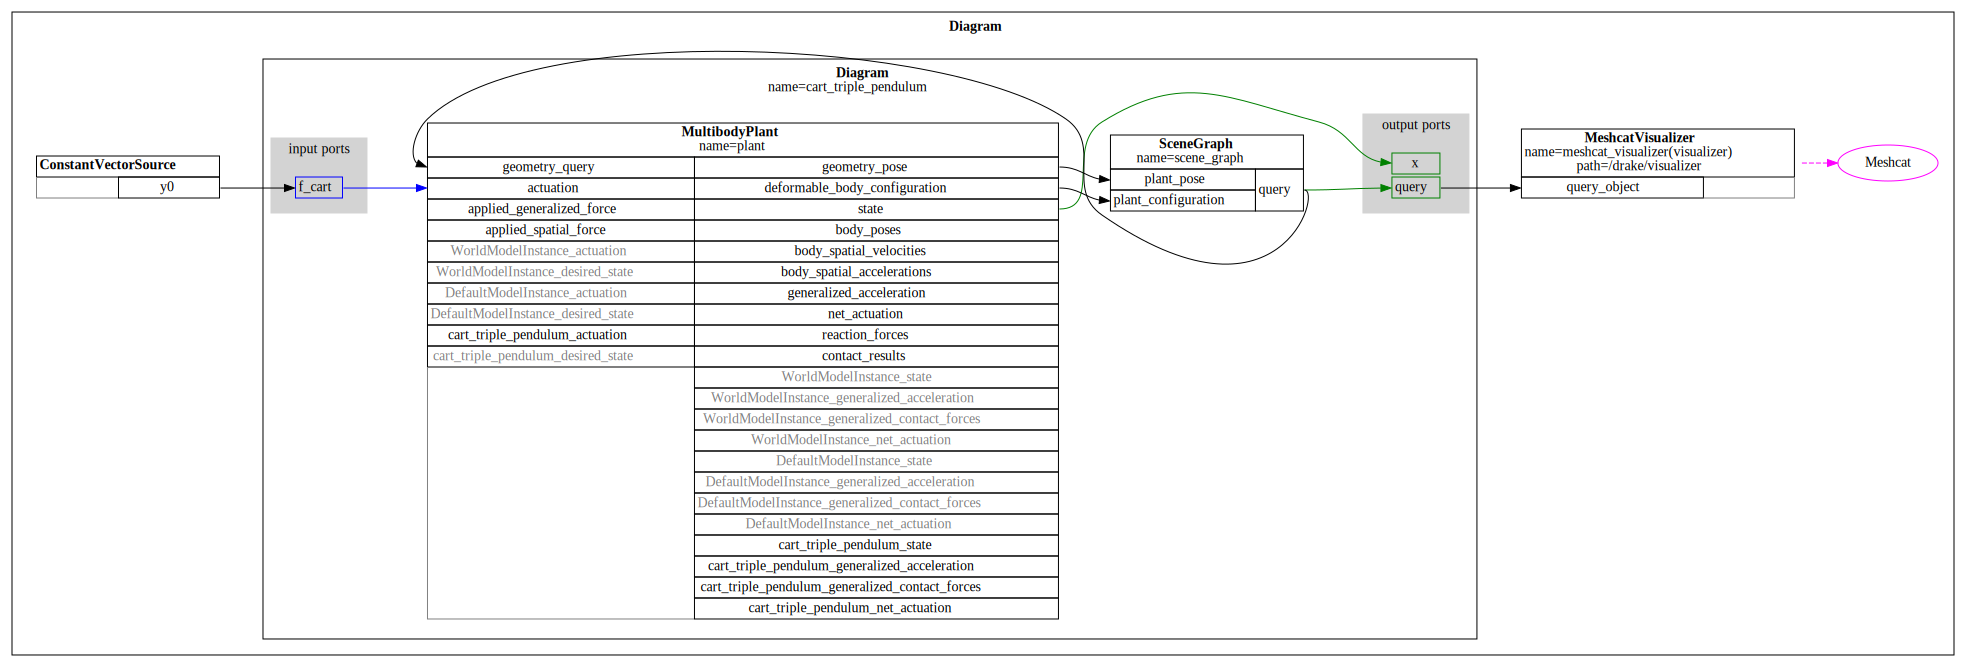

In [7]:
builder = DiagramBuilder()

cart_triple_pendulum = CartTriplePendulumPlant()
builder.AddNamedSystem("cart_triple_pendulum", cart_triple_pendulum)

force = ConstantVectorSource([5])
builder.AddSystem(force)
builder.Connect(force.get_output_port(), cart_triple_pendulum.get_input_port(0))

visualizer = MeshcatVisualizer.AddToBuilder(builder, cart_triple_pendulum.get_output_port(1), meshcat)

diagram = builder.Build()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

simulator = Simulator(diagram)


x0 = [0, np.deg2rad(0), 0, 0, 0, 0, 0, 0]
context = simulator.get_mutable_context()
context.SetContinuousState(x0)

simulator.Initialize()

visualizer.StartRecording(False)
simulator.AdvanceTo(3)
visualizer.PublishRecording()